In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt

from antea.io.mc_io import load_mcparticles
from antea.io.mc_io import load_mcsns_response
from antea.io.mc_io import load_sns_positions
from antea.io.mc_io import load_mchits

import antea.reco.mctrue_functions as mcf
import antea.reco.reco_functions   as rf

import matplotlib.patches as patches

In [2]:
filespath = '/Users/carmenromoluque/nexus_petit_analysis/tof_setup/PetBox_analysis/data_h5/'
filename  = filespath + 'PetBox_asymmetric_HamamatsuVUV.2500.pet.h5'

sns_positions = load_sns_positions(filename)
sens_xpos     = sns_positions.x.values
sens_ypos     = sns_positions.y.values
sens_zpos     = sns_positions.z.values
sens_ids      = sns_positions.sensor_id.values
mcparticles   = load_mcparticles(filename)
mchits        = load_mchits(filename)
sns_response  = load_mcsns_response(filename)

DataSiPM      = sns_positions.rename(columns={"sensor_id": "SensorID","x": "X", "y": "Y", "z": "Z"})
DataSiPM_idx  = DataSiPM.set_index('SensorID')

In [3]:
evts_path = '/Users/carmenromoluque/nexus_petit_analysis/tof_setup/PetBox_analysis/each_tile/data_charge_select_areas_each_tile/'

chargs_phot0, chargs_phot1, chargs_phot2, chargs_phot3, chargs_phot4 = [], [], [], [], []
for filename in os.listdir(evts_path):
    if filename.endswith('.npz'):
        my_file = evts_path+filename        
        d = np.load(my_file, allow_pickle=True)
        for i in d['chargs_phot'][0]:
            chargs_phot0.append(i)
        for i in d['chargs_phot'][1]:
            chargs_phot1.append(i)
        for i in d['chargs_phot'][2]:
            chargs_phot2.append(i)
        for i in d['chargs_phot'][3]:
            chargs_phot3.append(i)
        for i in d['chargs_phot'][4]:
            chargs_phot4.append(i)

chargs_phot    = np.array([np.array(chargs_phot0), np.array(chargs_phot1), 
                           np.array(chargs_phot2), np.array(chargs_phot3),
                           np.array(chargs_phot4)])

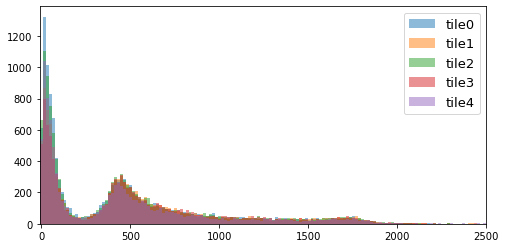

In [4]:
fig = plt.figure(figsize=(8,4))
for nc, charge in enumerate(chargs_phot):
    plt.hist(charge, 150, (-10, 2500), alpha=0.5, label=f'tile{nc}')
    plt.xlim(-10, 2500)
    plt.legend(fontsize=13)

## Events in the charge peaks in tile 5

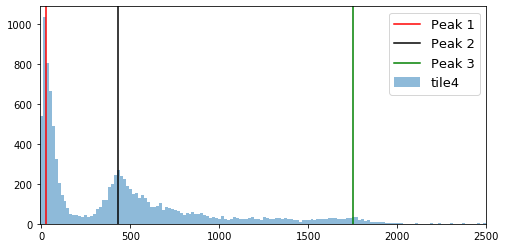

In [5]:
fig = plt.figure(figsize=(8,4))
plt.hist(chargs_phot[4], 150, (-10, 2500), alpha=0.5, label=f'tile{nc}')
plt.axvline(x=25, c='r', label='Peak 1')
plt.axvline(x=430, c='k', label='Peak 2')
plt.axvline(x=1750, c='g', label='Peak 3')
plt.xlim(-10, 2500)
plt.legend(fontsize=13);

In [6]:
evts_tile5 = [25000634, 25001337, 25002179, 25002814, 25002864, 25002350, 25002428, 25002873, 25003084, 25002540]
ch_evt_t5  = [      73,       50,       18,       72,       49,      414,      428,      405,      486,     1756]

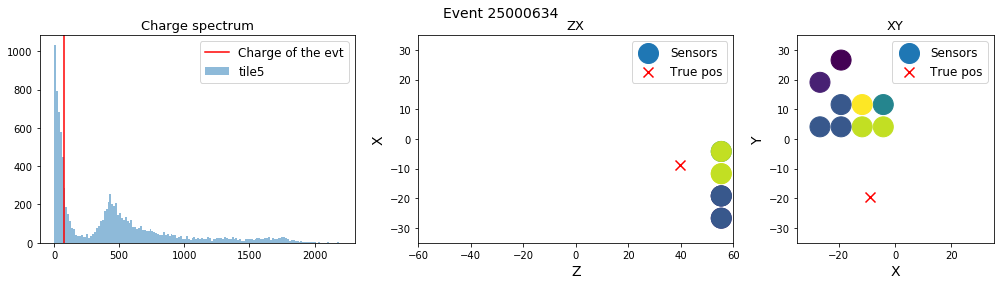

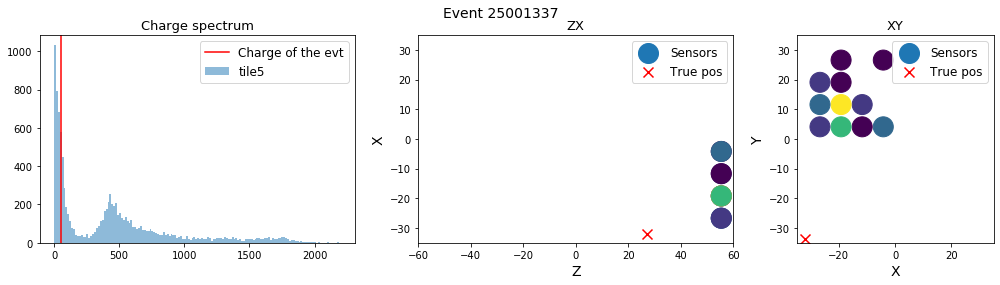

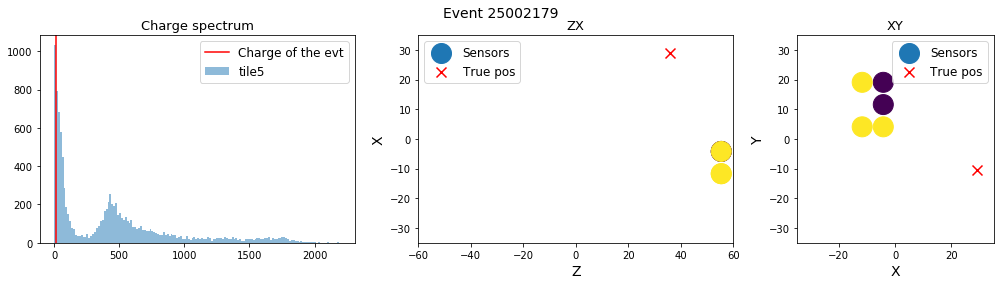

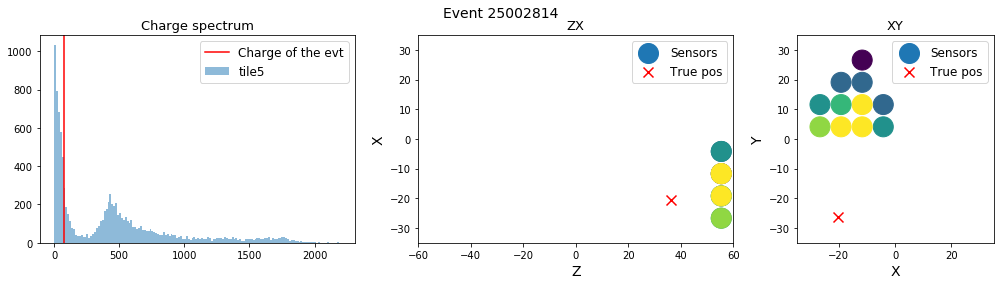

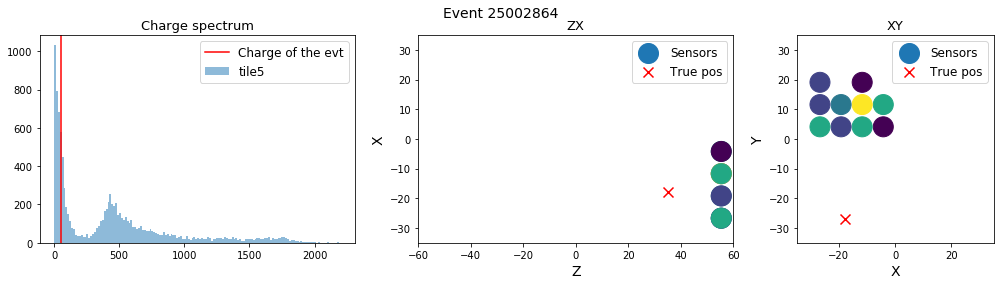

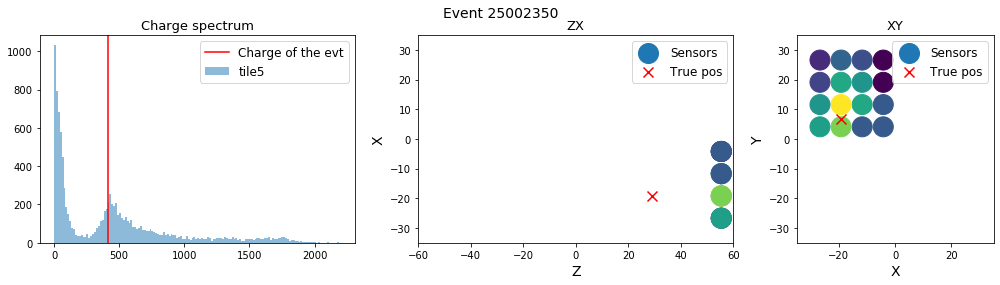

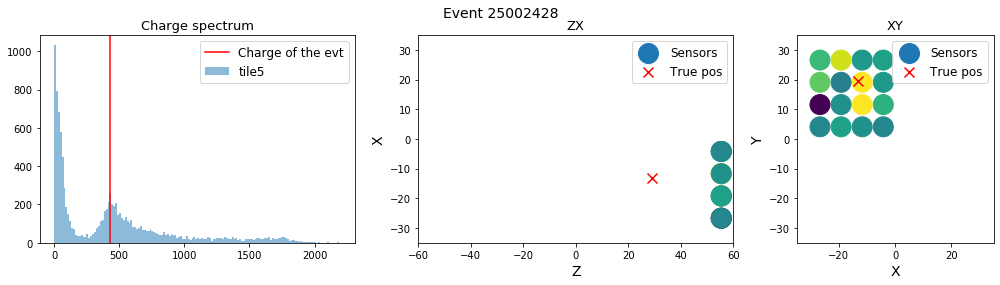

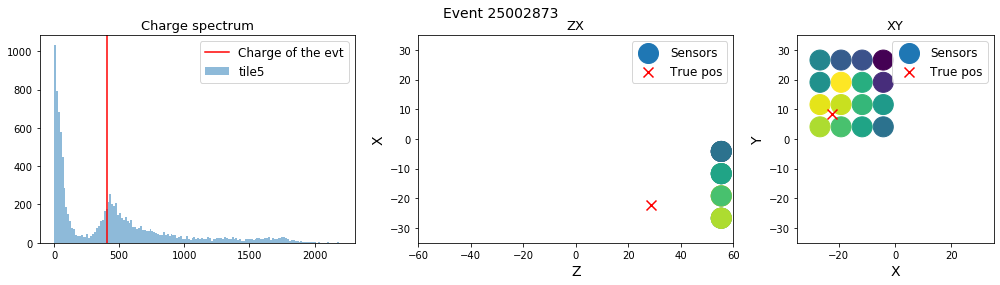

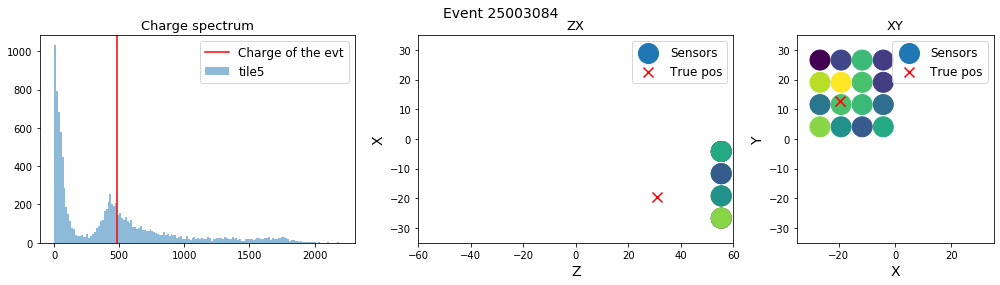

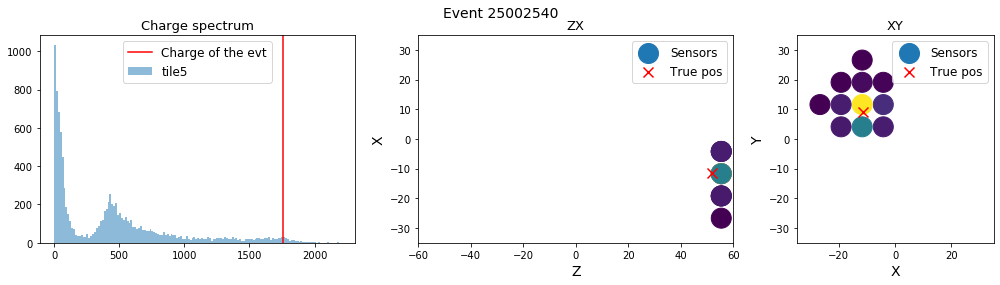

In [7]:
threshold = 2
for evt,ch in zip(evts_tile5, ch_evt_t5):
    #True info
    evt_parts = mcparticles[mcparticles.event_id == evt]
    evt_hits  = mchits     [mchits     .event_id == evt]
    phot, true_phot = mcf.select_photoelectric(evt_parts, evt_hits)
    
    #Sensors info
    evt_sns = sns_response[sns_response.event_id == evt]
    evt_sns = rf.find_SiPMs_over_threshold(evt_sns, threshold=threshold)
    sipms   = DataSiPM_idx.loc[evt_sns.sensor_id]
    ids     = sipms.index.astype('int64').values
    pos     = np.array([sipms.X.values, sipms.Y.values, sipms.Z.values]).transpose()
    qs      = evt_sns.charge.values
    
    tx_pos = np.array([tpos[0] for tpos in true_phot])
    ty_pos = np.array([tpos[1] for tpos in true_phot])
    tz_pos = np.array([tpos[2] for tpos in true_phot])
    
    pos_xs = np.array(pos.T[0])
    pos_ys = np.array(pos.T[1])
    pos_zs = np.array(pos.T[2])
    sel = pos_zs > 0
    
    #plt.rcParams["figure.figsize"] = (8,5)
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(14,4),gridspec_kw={'width_ratios': [1.6, 1.6, 1]})
    ranges_xy = (-35, 35)
    ranges_z  = (-60, 60)
    
    ax1.hist(chargs_phot[4], 150, (-1, 2200), alpha=0.5, label=f'tile5')
    ax1.axvline(x=ch, c='r', label='Charge of the evt')
    ax1.set_title(f"Charge spectrum", fontsize=13)
    ax1.legend(fontsize=12)
    
    ax2.scatter(pos_zs[sel], pos_xs[sel], c=qs[sel], s=400, label='Sensors')
    ax2.scatter(tz_pos, tx_pos, marker='x', color='r', s=100, label='True pos')
    ax2.set_xlim(ranges_z)
    ax2.set_ylim(ranges_xy)
    ax2.set_xlabel('Z', size=14)
    ax2.set_ylabel('X', size=14)
    ax2.set_title(f"ZX", fontsize=13)
    ax2.legend(fontsize=12)
    
    ax3.scatter(pos_xs[sel], pos_ys[sel], c=qs[sel], s=400, label='Sensors')
    ax3.scatter(tx_pos, ty_pos, marker='x', color='r', s=100, label='True pos')
    ax3.set_xlim(ranges_xy)
    ax3.set_ylim(ranges_xy)
    ax3.set_xlabel('X', size=14)
    ax3.set_ylabel('Y', size=14)
    ax3.set_title(f"XY", fontsize=13)
    ax3.legend(fontsize=12)
    
    #plt.colorbar().set_label("Number of events")
    fig.suptitle(f"Event {evt}", fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()

## Events in tile0:

In [8]:
evts_tile0 = [25001543, 25001587, 25002480, 25002541, 25002786, 25000706, 25001055, 25001319, 25002872, 25003268]
ch_evt_t0  = [       7,        3,       20,       61,       18,      491,      811,      401,      436,     1826]

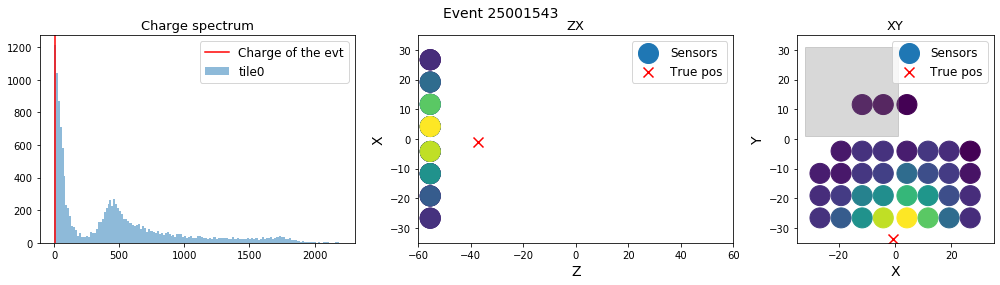

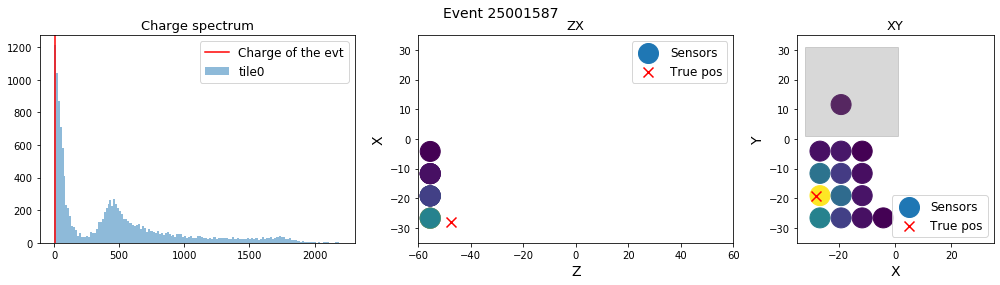

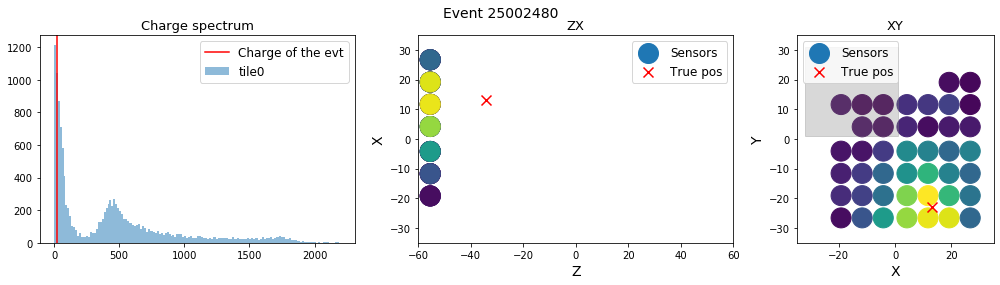

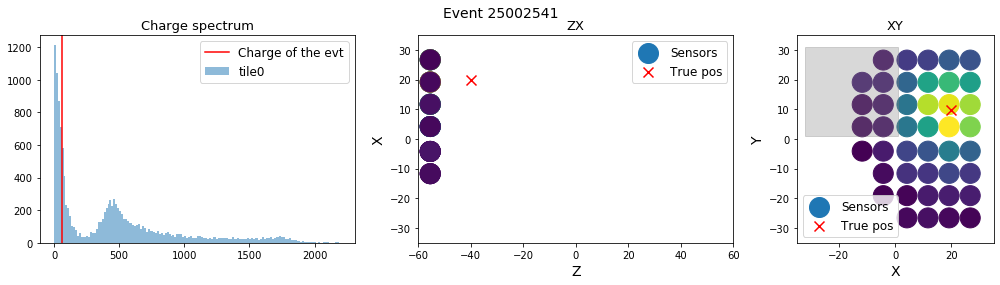

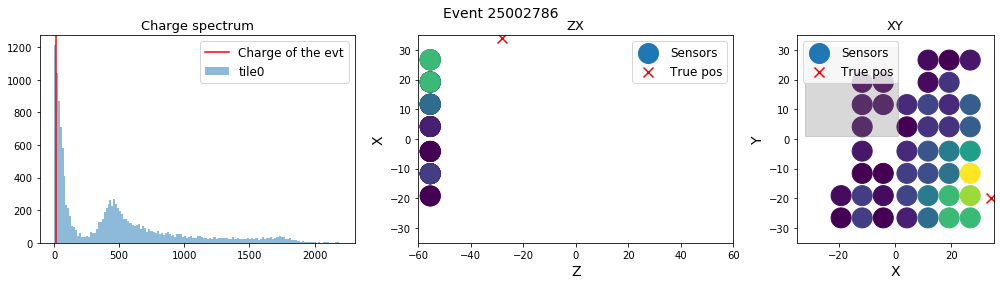

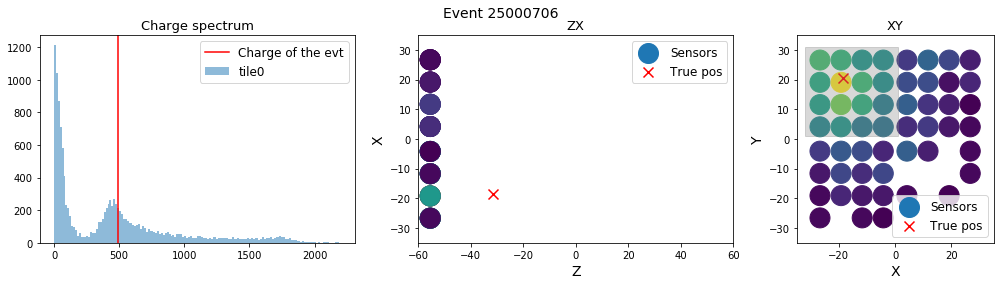

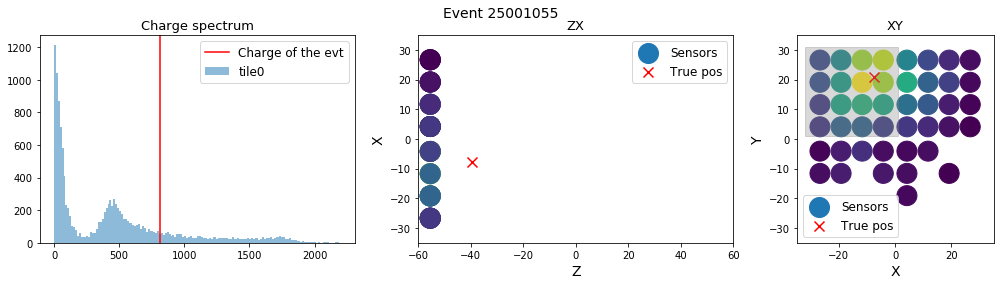

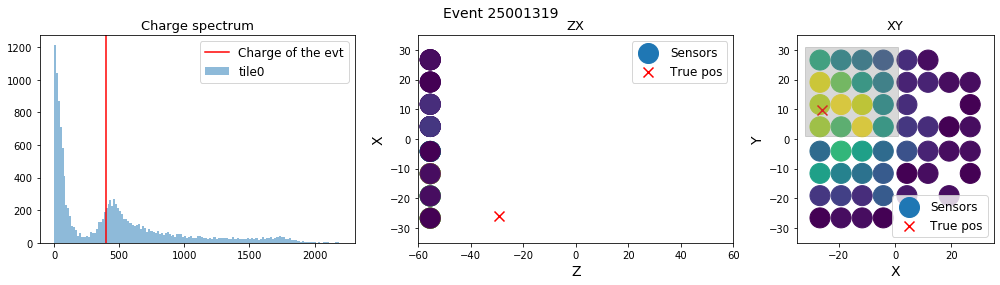

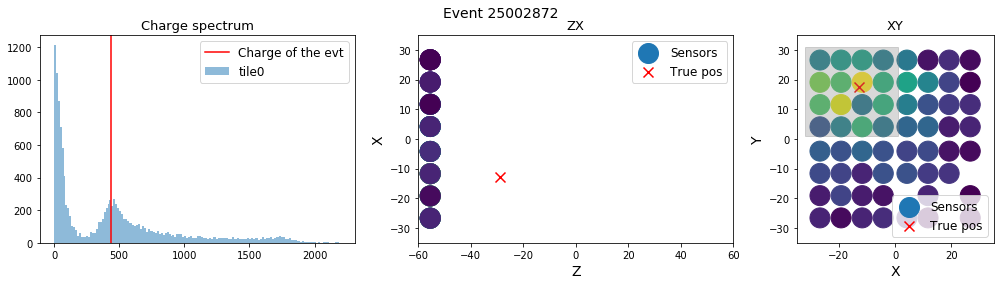

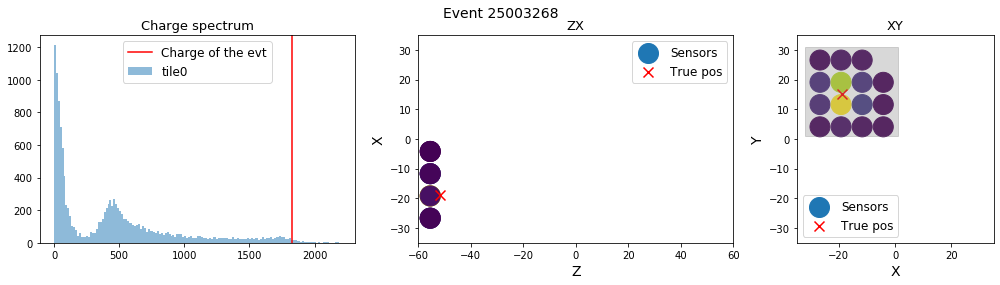

In [9]:
threshold = 2
for evt,ch in zip(evts_tile0, ch_evt_t0):
    #True info
    evt_parts = mcparticles[mcparticles.event_id == evt]
    evt_hits  = mchits     [mchits     .event_id == evt]
    phot, true_phot = mcf.select_photoelectric(evt_parts, evt_hits)
    
    #Sensors info
    evt_sns = sns_response[sns_response.event_id == evt]
    evt_sns = rf.find_SiPMs_over_threshold(evt_sns, threshold=threshold)
    sipms   = DataSiPM_idx.loc[evt_sns.sensor_id]
    ids     = sipms.index.astype('int64').values
    pos     = np.array([sipms.X.values, sipms.Y.values, sipms.Z.values]).transpose()
    qs      = evt_sns.charge.values
    
    tx_pos = np.array([tpos[0] for tpos in true_phot])
    ty_pos = np.array([tpos[1] for tpos in true_phot])
    tz_pos = np.array([tpos[2] for tpos in true_phot])
    
    pos_xs = np.array(pos.T[0])
    pos_ys = np.array(pos.T[1])
    pos_zs = np.array(pos.T[2])

    sel    = pos_zs < 0
    sel_tp = tz_pos < 0
    
    #plt.rcParams["figure.figsize"] = (8,5)
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(14,4),gridspec_kw={'width_ratios': [1.6, 1.6, 1]})
    ranges_xy = (-35, 35)
    ranges_z  = (-60, 60)
    
    ax1.hist(chargs_phot[0], 150, (-1, 2200), alpha=0.5, label=f'tile0')
    ax1.axvline(x=ch, c='r', label='Charge of the evt')
    ax1.set_title(f"Charge spectrum", fontsize=13)
    ax1.legend(fontsize=12)
    
    ax2.scatter(pos_zs[sel], pos_xs[sel], c=qs[sel], s=400, label='Sensors')
    ax2.scatter(tz_pos[sel_tp], tx_pos[sel_tp], marker='x', color='r', s=100, label='True pos')
    ax2.set_xlim(ranges_z)
    ax2.set_ylim(ranges_xy)
    ax2.set_xlabel('Z', size=14)
    ax2.set_ylabel('X', size=14)
    ax2.set_title(f"ZX", fontsize=13)
    ax2.legend(fontsize=12)
    
    # Create a Rectangle patch
    rect = patches.Rectangle((-32, 1), 33, 30, linewidth=1, edgecolor='grey', facecolor='grey', alpha=0.3)
    # Add the patch to the Axes
    ax3.add_patch(rect)
    ax3.scatter(pos_xs[sel], pos_ys[sel], c=qs[sel], s=400, label='Sensors')
    ax3.scatter(tx_pos[sel_tp], ty_pos[sel_tp], marker='x', color='r', s=100, label='True pos')
    
    ax3.set_xlim(ranges_xy)
    ax3.set_ylim(ranges_xy)
    ax3.set_xlabel('X', size=14)
    ax3.set_ylabel('Y', size=14)
    ax3.set_title(f"XY", fontsize=13)
    ax3.legend(fontsize=12)
    
    #plt.colorbar().set_label("Number of events")
    fig.suptitle(f"Event {evt}", fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()

## Events between peaks in tile2

In [10]:
evts_tile2 = [25001518, 25001834, 25002786, 25003473, 25000110, 25000328, 25002392, 25002655, 25000731, 25001452]
ch_evt_t2  = [      45,       16,       43,        6,      532,      427,      454,      438,     1732,     1807]

evts_tile2_inter = [25000363, 25003230, 25001998, 25001653]
ch_evt_t2_inter  = [     739,      823,     1013,     1431]

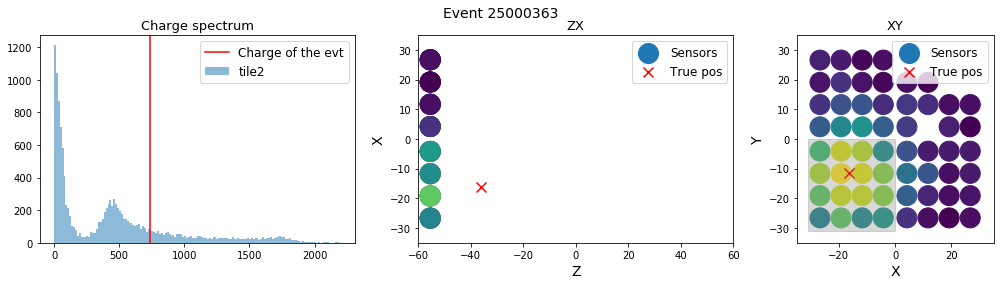

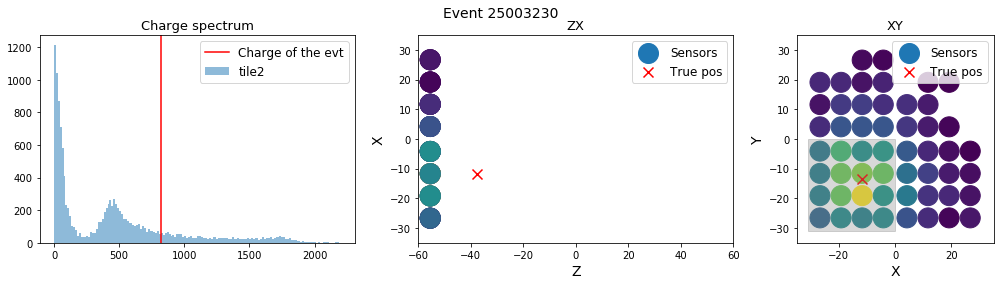

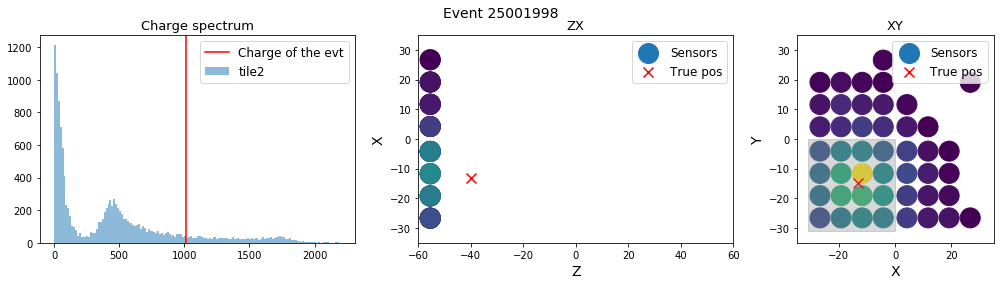

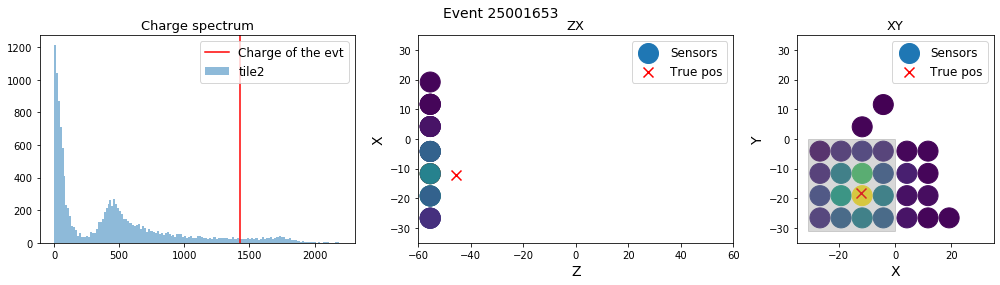

In [11]:
threshold = 2
for evt,ch in zip(evts_tile2_inter, ch_evt_t2_inter):
    #True info
    evt_parts = mcparticles[mcparticles.event_id == evt]
    evt_hits  = mchits     [mchits     .event_id == evt]
    phot, true_phot = mcf.select_photoelectric(evt_parts, evt_hits)
    
    #Sensors info
    evt_sns = sns_response[sns_response.event_id == evt]
    evt_sns = rf.find_SiPMs_over_threshold(evt_sns, threshold=threshold)
    sipms   = DataSiPM_idx.loc[evt_sns.sensor_id]
    ids     = sipms.index.astype('int64').values
    pos     = np.array([sipms.X.values, sipms.Y.values, sipms.Z.values]).transpose()
    qs      = evt_sns.charge.values
    
    tx_pos = np.array([tpos[0] for tpos in true_phot])
    ty_pos = np.array([tpos[1] for tpos in true_phot])
    tz_pos = np.array([tpos[2] for tpos in true_phot])
    
    pos_xs = np.array(pos.T[0])
    pos_ys = np.array(pos.T[1])
    pos_zs = np.array(pos.T[2])

    sel    = pos_zs < 0
    sel_tp = tz_pos < 0
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(14,4),gridspec_kw={'width_ratios': [1.6, 1.6, 1]})
    ranges_xy = (-35, 35)
    ranges_z  = (-60, 60)
    
    ax1.hist(chargs_phot[0], 150, (-1, 2200), alpha=0.5, label=f'tile2')
    ax1.axvline(x=ch, c='r', label='Charge of the evt')
    ax1.set_title(f"Charge spectrum", fontsize=13)
    ax1.legend(fontsize=12)
    
    ax2.scatter(pos_zs[sel], pos_xs[sel], c=qs[sel], s=400, label='Sensors')
    ax2.scatter(tz_pos[sel_tp], tx_pos[sel_tp], marker='x', color='r', s=100, label='True pos')
    ax2.set_xlim(ranges_z)
    ax2.set_ylim(ranges_xy)
    ax2.set_xlabel('Z', size=14)
    ax2.set_ylabel('X', size=14)
    ax2.set_title(f"ZX", fontsize=13)
    ax2.legend(fontsize=12)
    
    # Create a Rectangle patch
    rect = patches.Rectangle((-31, -31), 31, 31, linewidth=1, edgecolor='grey', facecolor='grey', alpha=0.3)
    # Add the patch to the Axes
    ax3.add_patch(rect)
    ax3.scatter(pos_xs[sel], pos_ys[sel], c=qs[sel], s=400, label='Sensors')
    ax3.scatter(tx_pos[sel_tp], ty_pos[sel_tp], marker='x', color='r', s=100, label='True pos')
    
    ax3.set_xlim(ranges_xy)
    ax3.set_ylim(ranges_xy)
    ax3.set_xlabel('X', size=14)
    ax3.set_ylabel('Y', size=14)
    ax3.set_title(f"XY", fontsize=13)
    ax3.legend(fontsize=12, loc=1)
    
    fig.suptitle(f"Event {evt}", fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()